## Step 1 - load in all the info we need, e.g. sentiment information

In [6]:
import io 
import re
from constraints import get_id_and_value_map
from constraints import IDENTITY_PREFIX, SENTWORD_PREFIX
from vaderSentiment.vaderSentiment import WORD_VALENCE_DICT

# read in sentiment word values
sent_to_id = {}
sent_values = {}
for i,x in enumerate(io.open("../data/sentiment_data/clean_epa_terms.txt")):
    x_spl = x.split("\t")
    word = x_spl[0]
    id_val = SENTWORD_PREFIX + str(i) 
    sent_to_id[word] = id_val
    sent_values[id_val +'e'] = float(x_spl[1])+.0001
    sent_values[id_val +'p'] = float(x_spl[2])+.0001
    sent_values[id_val +'a'] = float(x_spl[3])+.0001

# make up identity values
identities = {x.strip() for x in 
              io.open("../data/identity_data/final_identities_list.txt").readlines()}
identity_to_id = {identity : IDENTITY_PREFIX+str(i) for i, identity in enumerate(identities)}
id_to_identity = {v : k for k, v in identity_to_id.items()}

# get grams to compbine
gram_list = set(identity_to_id.keys())|set(sent_to_id.keys())

# get emoji, emoticon data, hashtag data
emoji_data = {x.split("\t")[0] : float(x.strip().split("\t")[1])
                    for x in io.open("../data/sentiment_data/emoji_sent_data.tsv")}
emoji_regex = re.compile("|".join(emoji_data.keys()))
emoticon_data = {x.split("\t")[0] : float(x.strip().split("\t")[1])
                    for x in io.open("../data/sentiment_data/emoticon_sent_data.tsv")}
hashtag_data = {}
for line in io.open("../data/sentiment_data/nrc_epa_hashtags.tsv"):
    line_spl = line.strip().split("\t")
    hashtag_data[line_spl[0]] = [float(x) for x in line_spl[1:]]
    
# get vader dict without our identities
vader_sent_dict = WORD_VALENCE_DICT.copy()
for i in identities:
    if i in vader_sent_dict:
        del vader_sent_dict[i]

### Step 1a: Configure Spark

In [9]:
import logging
from pyspark import SparkContext, SparkConf

conf = (SparkConf()
     .setMaster("local[*]")
     .setAppName("My app")
     .set("spark.driver.maxResultSize", "50g"))
sc = SparkContext(conf=conf)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Step 2: Get Text Units from a file/files

In [ ]:
from twitter_dm.utility.general_utils import read_grouped_by_newline_file

data = read_grouped_by_newline_file("../data/ferg_geo_data/recent/fin/125.txt")

In [ ]:
# To Test
default_textunit_args = {"use_events": False,
                         "use_behaviors": False,
                         "use_isa": False,
                         "use_own_full_sentence" : False,
                         "emoticon_to_eval_dim" : False,
                         "use_parent_child" : False,
                         "hashtag_epa_data" : False,
                         "vader_dict" : False,
                         "emoji_info" : False,
                         "use_clause_level" : True,
                         "do_negation_on_full_sentence" : True
                        }

addtl_models = {"w_beh" : {"use_behaviors": True},
                "w_event" : {"use_events" : True},
                "event_only" : {"use_events": True, "use_own_full_sentence": False, "use_clause_level" : True},
                "nothing" : {"use_own_full_sentence": False},
                #"w_isa" : {"use_isa": True},
                "w_emoticon" : {"emoticon_to_eval_dim" : emoticon_data},
                #"w_ht" : {"hashtag_epa_data": hashtag_data},
                #"w_vader" : {"vader_dict" : vader_sent_dict},
                #"w_pc" : {"use_parent_child" : True},
                "w_emoji" : {"emoji_info": [emoji_data,emoji_regex]},
                "no_negation" : {"do_negation_on_full_sentence" : False},
                "full_mod" : {"use_events":True },
                "full_mod_b" : {"do_negation_on_full_sentence" : True,"use_events":True, 
                                "use_behaviors":True, "use_isa" : True }}

In [ ]:
import textunit
def get_textunit_info(x):
    spl = x[0].split("\t")
    uid = spl[11]
    tweet_id =  spl[10]
    date = x[0].split("\t")[-2]
    
    tu_models = {}
    
    s = textunit.TextUnit(uid+ "\t" + tweet_id, date,
                     sent_to_id,identity_to_id,gram_list,
                     dependency_parsed_conll=x,
                     sent_values=sent_values,
                     **default_textunit_args)
    tu_models["default"] = s

    for key, addtl_model in addtl_models.items():
        def_cpy = default_textunit_args.copy()
        def_cpy.update(addtl_model)
        s = textunit.TextUnit(uid+ "\t" + tweet_id, date,
                     sent_to_id,identity_to_id,gram_list,
                     dependency_parsed_conll=x,
                     sent_values=sent_values,
                     **def_cpy)
        tu_models[key] = s
    return [tu_models]

# k = get_textunit_info(data[1])
# for x in k[0].values():
#     print x.identities, x.full_deflection_string, x.all_constraints,x.raw_text, x.use_clause_level
textunits = sc.parallelize(data,320).flatMap(get_textunit_info).collect()

In [ ]:
import cPickle as pickle
pickle.dump(textunits, open("textunits_eval_constraint_model.p","wb"))

In [1]:
import cPickle as pickle
textunits = pickle.load(open("textunits_eval_constraint_model.p"))

## Step 3: Convert To Users

In [2]:
from collections import defaultdict

# split into sets of tweets for each type of textunit
user_tweets = defaultdict(list)
for textunits_dict in textunits:
    for k, v in textunits_dict.items():
        user_tweets[k].append(v)

In [3]:
import user
user_sets = {k : user.get_users_from_tweet_list(tweetlist,30,.15) for k, tweetlist in user_tweets.items()}

In [4]:
len(user_sets.items()[0][1])

360

## Step 4: "Train" A Toy Model for each type of textunit

In [7]:
# get default/base values
import numpy as np
import io
base_identity_sent_vals = {}
poss_sent_vals = {x.strip().split("\t")[0]: x.strip().split("\t")[1:] 
                      for x in io.open("../data/sentiment_data/clean_epa_terms.txt")}
for iden_id, identity in id_to_identity.items():
    e, p, a = [float(x) for x in poss_sent_vals.get(identity, [.4775899+np.random.uniform(-1,1),
                                                               0.5816139+np.random.uniform(-1,1),
                                                               0.4352551+np.random.uniform(-1,1)])]
    base_identity_sent_vals[iden_id+'e']= e
    base_identity_sent_vals[iden_id+'p']= p
    base_identity_sent_vals[iden_id+'a']= a

In [8]:
import numpy as np
def get_user_sent_dict(values, training_tweets):
    user_sent_dict = defaultdict(float)
    uv = type("Cat", (object,),values)
    for iden, constr_all_tweets in training_tweets:
        res = np.array([-eval(str(x[1]))/(2*eval(str(x[0]))) 
                            for x in constr_all_tweets]).mean()
        user_sent_dict[iden] = res
    return user_sent_dict

def get_sent_dicts_for_all_users_in_set(users, base_values):
    user_our_full_sent_data =  {}
    for u in users:
        # iterate twice, like a little EM -ish alg
        user_sent_dict = get_user_sent_dict(base_values, u.training_id_to_tweets.items())
        user_values = {v : user_sent_dict.get(v,k) for v,k in base_values.items()}
        user_sent_dict = get_user_sent_dict(user_values, u.training_id_to_tweets.items())
        user_our_full_sent_data[u.uid] = user_sent_dict
    return user_our_full_sent_data

In [9]:
# get uid -> identity_epa -> mean_sent_value for all user sets for each user
user_to_sent_dicts = {k: get_sent_dicts_for_all_users_in_set(users, base_identity_sent_vals) 
                      for k, users in user_sets.items()}

In [10]:
user_to_sent_dicts.keys()

['w_emoticon',
 'event_only',
 'default',
 'full_mod',
 'full_mod_b',
 'w_beh',
 'nothing',
 'w_event',
 'w_emoji',
 'no_negation']

## Step 5: Evaluate the toy models against the baseline sentiment model

In [11]:
index_to_id = identity_to_id.values()
id_to_index = {k : i for i,k in enumerate(index_to_id)}

### Step 5a: Run the baseline model

In [78]:
from math import log
from vaderSentiment.vaderSentiment import sentiment
from pred_models import SimpleSent
from vaderSentiment.vaderSentiment import sentiment
from twitter_dm.utility.general_utils import tab_stringify_newline as tsn


## doesn't matter which user set we use, they're all the same, so just go with one
users = user_sets.values()[0]

In [79]:
def get_sentiment_for_line(line):
    uid, identities, text = line.strip().split("\t")
    identities = identities.split(",")
    sent = sentiment(text,vader_sent_dict,alpha_normalizer=15.)['compound']
    for identity in identities:
        yield ((uid, identity), sent)
        
# write out the raw text so we can build the baseline sentiment model elsewhere
training_raw_text_out = io.open("training_for_find_best_constraint_raw_text.txt","w")
for j, u in enumerate(users):
    if j % 100 == 0:
        print j
    uid = u.uid
    for i, raw_text in enumerate(u.training_raw_text):
        training_raw_text_out.write(tsn([uid,
                                         u",".join(u.training_identities_per_tweet[i]),
                                         raw_text]))
training_raw_text_out.close()

0
100
200
300


In [82]:
raw_text = sc.textFile("training_for_find_best_constraint_raw_text.txt",128)
sent_per_uid_identity = (raw_text.flatMap(get_sentiment_for_line)
                         .aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                                 lambda a,b: (a[0] + b[0], a[1] + b[1]))
                          .mapValues(lambda v: float(v[0])/float(v[1])).collect())
import pandas as pd
simple_sent_data = pd.DataFrame([ [x[0],x[1], y] for x, y in sent_per_uid_identity])
simple_sent_data.columns = ['uid','iden_id','val']

In [83]:
import pandas as pd 

# construct simple sentiment info for simple sent models
i2ind = pd.DataFrame(id_to_index.items())
i2ind.columns = ['iden_id','index']

overall_simple_sent = simple_sent_data[['iden_id','val']].groupby("iden_id").mean().reset_index()
overall_simple_sent = pd.merge(overall_simple_sent,i2ind, on='iden_id')
simple_sent_vector = np.zeros(len(i2ind))
for x in overall_simple_sent.values.tolist():
    simple_sent_vector[x[2]] = x[1]

user_simple_sent_data = defaultdict(dict)
for x in simple_sent_data.values.tolist():
    if x[1] in id_to_index:
        user_simple_sent_data[x[0]][x[1]] = x[2]

In [84]:
pv = 2
rsv = 1

n_identities = len(identities)
simp_sent = SimpleSent("sent_basic", simple_sent_vector, id_to_index, rescale_value=rsv, power_val=pv)
perpl = defaultdict(int)
spot = []
n_tot_obs = 0
for u in users:
    user_simple_sent = SimpleSent("u_sent", simple_sent_vector, id_to_index, rescale_value=rsv, 
                                  user_sent_info=user_simple_sent_data[u.uid], power_val=pv)
    sent_models = [simp_sent,user_simple_sent]
    sent_probs = {}

    for tw_iter, test_text in enumerate(u.test_raw_text):
        # do simple sent stuff
        test_sent = sentiment(test_text, vader_sent_dict)['compound']
        for m in sent_models:
            sent_probs[m.name()] = m.compute_prob(test_sent)
          
        test_string = u.test_deflection_strings[tw_iter].replace("uv.","self.uv.")

        for identity in u.test_identities_per_tweet[tw_iter]:
            n_tot_obs += 1
            index_of_identity = id_to_index[identity]
            for name, probs in sent_probs.items():
                perpl[name] += log(probs[index_of_identity])
            if (not len(test_string) or 
                    (identity+'e' not in test_string and
                     identity+'p' not in test_string and
                     identity+'a' not in test_string)):
                pass
            else:
                spot.append(np.where((-probs).argsort() == index_of_identity)[0][0])
print n_tot_obs
for k, v in perpl.items():
    print k, v/float(n_tot_obs)
print np.mean(spot)

18666
sent_basic -5.71722397306
u_sent -5.69977269226
129.249103124


### Step 5b Run each of the textunit models

In [36]:
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})

In [93]:
from math import log
from pred_models import OurSent
from collections import Counter

n_identities = len(identities)
#perpl = defaultdict(int)

eq_prob = 1./float(n_identities)

for us_key in user_sets.keys():
    user_our_full_sent_data = user_to_sent_dicts[us_key]
    users = user_sets[us_key]
    n_tot_obs = 0
    perpl = 0
    spot = []
    #compute user average
    count = Counter()
    val_count = Counter()
    for user, id_to_val_dict in user_our_full_sent_data.items():
        for iden_id, val in id_to_val_dict.items():
            count[iden_id] += 1
            val_count[iden_id] += val
    user_avg = {}
    for k, v in base_identity_sent_vals.items():
        if count[k]:
            user_avg[k] = (float(val_count[k]) + v)/(count[k]+1)
        else:
            print 'here'
            user_avg[k] = v
    
    for u in users:
        ud = user_our_full_sent_data[u.uid]
        user_values = {k: ud.get(k,v) for k,v in user_avg.items()}
        our_sent = OurSent(index_to_id,user_values)

        for tw_iter, test_text in enumerate(u.test_raw_text):
            # get defl string for our model
            test_string = u.test_deflection_strings[tw_iter].replace("uv.","self.uv.")

            for identity in u.test_identities_per_tweet[tw_iter]:
                n_tot_obs += 1
                if (not len(test_string) or 
                    (identity+'e' not in test_string and
                     identity+'p' not in test_string and
                     identity+'a' not in test_string)):
                    perpl += log(eq_prob)
                else:
                    se_prob = our_sent.compute_prob(identity, test_string)
                    spot.append(np.where((-se_prob).argsort() == id_to_index[identity])[0][0])
                    perpl += log(se_prob[id_to_index[identity]])

    print us_key,  n_tot_obs, perpl/float(n_tot_obs), perpl, np.mean(spot), len(spot)

w_emoticon 18666 -12.4723438254 -232808.769846 144.546604918 15331
event_only 18666 -12.427738755 -231976.1716 144.519016393 15250
default 18666 -12.4412231411 -232227.871152 144.576721311 15250
w_beh 18666 -12.4417302024 -232237.335958 144.498262637 15253
full_mod_b 18666 -12.4990777249 -233307.784814 144.511609654 15289
full_mod 18666 -12.427738755 -231976.1716 144.519016393 15250
nothing 18666 -12.4412231411 -232227.871152 144.576721311 15250
w_event 18666 -12.427738755 -231976.1716 144.519016393 15250
w_emoji 18666 -12.4464100427 -232324.689857 144.367933692 15443
no_negation 18666 -12.0660934824 -225225.700943 144.041442623 15250


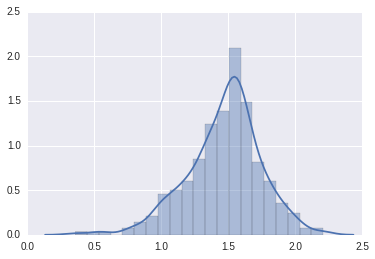

In [24]:
import seaborn as sns
sns.set()
%matplotlib inline
sns.distplot([x for k, x in user_avg.items() if k[-1] == 'p'])

In [ ]:
sc.stop()

In [91]:
# BASE
users = user_sets['nothing']
our_sent = OurSent(index_to_id,user_avg)
perpl = 0
n_tot_obs = 0
missed = 0
spot = []
for u in users:
    for tw_iter, test_text in enumerate(u.test_raw_text):
        # get defl string for our model
        test_string = u.test_deflection_strings[tw_iter].replace("uv.","self.uv.")

        #print test_string
        for identity in u.test_identities_per_tweet[tw_iter]:
            
            if (not len(test_string) or 
                (identity+'e' not in test_string and
                 identity+'p' not in test_string and
                 identity+'a' not in test_string)):
                #perpl += log(eq_prob)
                    
                missed += 1
            else:
                n_tot_obs += 1
                se_prob = our_sent.compute_prob(identity, test_string)
                spot.append(np.where((-se_prob).argsort() == id_to_index[identity])[0][0])
#                se_prob *= se_prob.sum()
#                se_prob = -np.log(se_prob)
#                 print test_string
#                 print u.test_raw_text[tw_iter]
#                 print id_to_identity[identity], "{0:.5f}".format(se_prob[id_to_index[identity]]), '\t',
#                 print user_avg[identity+"e"],user_avg[identity+"p"],user_avg[identity+"a"]
#                 print np.where((se_prob).argsort() == id_to_index[identity])[0][0]
#                 print 
#                 top = (se_prob).argsort()[:5]
#                 for x in top:
#                     print id_to_identity[index_to_id[x]], se_prob[x],"\t",
#                     print user_avg[index_to_id[x]+"e"],user_avg[index_to_id[x]+"p"],user_avg[index_to_id[x]+"a"]
#                 print
                perpl += log(se_prob[id_to_index[identity]])

print np.mean(spot), len(spot)
print n_tot_obs, perpl/float(n_tot_obs), perpl

138.54747541 15250
15250 -9.54578929663 -145573.286774


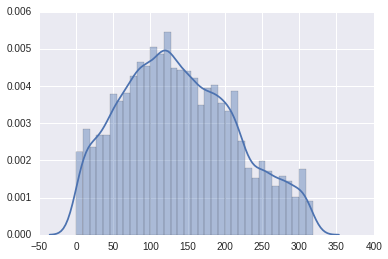

In [87]:
sns.distplot(spot)

In [67]:
(1.38599068423-0.71578088033)**2+ (1.65506963742-1.6730903537)**2 + (-0.906946173513+1.85466575121)**2

1.3476783254091007

##### 

In [10]:
import msgpack
import glob
files = glob.glob("../data/ferg_geo_data/recent/fin/*.txt")
len(files)
import numpy as np 
import io
import sys
import codecs
from collections import defaultdict

from user import User
import glob
import cPickle as pickle
import os
from twitter_dm.utility.general_utils import read_grouped_by_newline_file
from collections import defaultdict
from textunit import TextUnit

from constraints import get_id_and_value_map
from constraints import IDENTITY_PREFIX, SENTWORD_PREFIX

sys.stdout = codecs.getwriter('utf-8')(sys.stdout)
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})

def get_all_with_keyword(filename):
    ##### GET THE DATA 
    dep_parse = read_grouped_by_newline_file(filename)
    for i,x in enumerate(dep_parse):
        if any(['innocent' in y for y in x]):
            yield x
            
            
# f = io.open("thot_dat.txt","w")

# for fil in files:
#     print fil
#     for x in get_all_with_keyword(fil):
#         f.write("\n".join(x) + "\n\n")
#     break
# f.close()
    
terror_data = sc.parallelize(files, len(files)).flatMap(get_all_with_keyword).collect()

import io
f = io.open("innocent_dat.txt","w")
for x in terror_data:
    f.write("\n".join(x) + "\n\n")
f.close()

In [7]:
sc.stop()